In [270]:
import pandas as pd
import numpy as np
import os # DEBUG
from glob import glob
from pandas_profiling import ProfileReport
import yaml
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import category_encoders
%matplotlib inline

In [271]:
PATH_ABS_SRC = os.getcwd()
PATH_REL = os.path.dirname(os.getcwd())

# Mapping File

In [272]:
with open("naming.yaml") as stream:
    naming = yaml.safe_load(stream)

In [273]:
df = pd.read_csv('../data/profiles_revised.csv')

In [274]:
df.head()

,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,-1,transportation,"doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,36,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,hospitality / travel,"doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,37,thin,anything,socially,NaN,graduated from masters program,NaN,68.0,-1,NaN,NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,22,thin,vegetarian,socially,NaN,working on college/university,white,71.0,20000,student,doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,30,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",66.0,-1,artistic / musical / writer,NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


In [275]:
profile = ProfileReport(df, title='Pandas Profilign Report')
#profile.to_widgets() # does not show anything
profile.to_notebook_iframe()
profile.to_file("pandas_profiling_data_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [276]:
def print_col_values(list, filename):
    with open(r'{}.txt'.format(filename), 'w') as fp:
        for element in list:
            fp.write("{}\n".format(element))

# Zodiac Sign

In [277]:
# Extract Col
zodiacs = df.sign.unique()
print_col_values(list=zodiacs, filename='zodiacs')

ZODIAC_STRING_REPLACMENT = '&rsquo;' # corresponds to " ' "

# Clean
zodiacs = [z for z in zodiacs if str(z) != 'nan'] # remove nan values
zodiacs = [v.replace('&rsquo;', '\'') for v in zodiacs] # replace '

# Check
print_col_values(list=zodiacs, filename='zodiacs-cleaned')



In [278]:
# copy by value
df_zodiac = df.copy()

# nan's, and spelling
df_zodiac.dropna(inplace=True, subset=['sign']) # remove nan's
df_zodiac.shape # (48890, 19) , same as profiler

# extract only sign
df_zodiac['sign-extracted'] = df_zodiac['sign'].str.split(' ').str[0]

# extract sign modifier
df_zodiac['sign-modifier-extracted'] = df_zodiac['sign'].str.split(' ').str[1:]
df_zodiac['sign-modifier-extracted'] = df_zodiac['sign-modifier-extracted'].apply(lambda y: '' if len(y)==0 else y) # replace empty lists with ''
df_zodiac['sign-modifier-extracted'] = df_zodiac['sign-modifier-extracted'].apply(lambda y: ' '.join(y) if len(y)!=0 else y) # join list of strings together
df_zodiac['sign-modifier-extracted'] = df_zodiac['sign-modifier-extracted'].str.replace(ZODIAC_STRING_REPLACMENT,'\'')  # replace 

# map sign modifier + ordinal classifier
mapper_naming_dict = naming['zodiac_hiearchy'] 
df_zodiac['sign-modifier-extracted-ordinal'] =  df_zodiac['sign-modifier-extracted'].map(mapper_naming_dict).fillna(df_zodiac['sign-modifier-extracted']) # map values from dict according to string
df_zodiac[['sign', 'sign-extracted', 'sign-modifier-extracted', 'sign-modifier-extracted-ordinal']]

,sign,sign-extracted,sign-modifier-extracted,sign-modifier-extracted-ordinal
0,gemini,gemini,,
1,cancer,cancer,,
2,pisces but it doesn&rsquo;t matter,pisces,but it doesn't matter,0.0
3,pisces,pisces,,
4,aquarius,aquarius,,
...,...,...,...,...
59941,cancer and it&rsquo;s fun to think about,cancer,and it's fun to think about,1.0
59942,leo but it doesn&rsquo;t matter,leo,but it doesn't matter,0.0
59943,sagittarius but it doesn&rsquo;t matter,sagittarius,but it doesn't matter,0.0
59944,leo and it&rsquo;s fun to think about,leo,and it's fun to think about,1.0


# Languages

In [279]:
# Extract Col
lng = df.speaks.unique()
print_col_values(list=lng, filename='languages')

In [280]:
# copy by value
df_languages = df.copy()

# nan's
df_languages.dropna(inplace=True, subset=['speaks']) # remove nan's
df_languages.shape # (59896, 19) , same as profiler

df_languages['spoken_languages'] = np.nan
# structure: language (level), langauge2 .... || language, langauge2, ...
# due to the n:m relationship between persons and languages we will choose a one key encoding for the data
# to not overload the main dataframe we will create a separate df with the information of the languages and use teh same ID as in the main dataframe. The structure of the new df will look as followed:

########################################################
#  ID #  english  #  italian  #  spanish  # ... other # number of languages spoken
#  1       1           0           0         0    1           2
#  2       1           1           1         1    1           5
#  3       0           1           1         0    1           3
#  4       1           0           0         0    0           1
#  5       1           0           1         0    1           3
#
# extract language, without level => split by comma => multiple values, split by space, use first
#

# iterate through all values and create lists for all languages, userIDs and column names
allLanguages = list()
allIds = list()
languageColumns = list()
for row in df_languages.iterrows():
    languages = list()
    idsForPerson = list()
    # in this step the language is extracted (the appendix (spoken level e.g. fluid) removed)
    for language in row[1].speaks.split(','):
        languages.append(language.strip().split(' ')[0])
        # indexes are going to be added to the list for the next step (one hot key encoding)
        idsForPerson.append(row[0])
        languageColumns.append(language.strip().split(' ')[0])
    # allLanguages represents a list of languages [english, french, spanish]
    allLanguages.append(languages)
    # allIds represents a the list of the corresponding index [6, 6, 6] (for the lambda below)
    allIds.append(idsForPerson)

# remove all the duplicates from the column list
languageColumns = sorted(set(languageColumns))
encoded_df_languages = pd.DataFrame()
df_languages['language'] = allLanguages
encoded_df_languages['language'] = allLanguages
encoded_df_languages['userID'] = allIds

# split up the values from the array into new rows
# [english, french, spanish] will be 3 rows with the corresponding userID of 6, 6, 6 => df gets form 60k rows to 110k
encoded_df_languages =encoded_df_languages.apply(lambda x: pd.Series(np.concatenate(x.tolist())), 0)

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'language' column
encoder_df = pd.DataFrame(encoder.fit_transform(encoded_df_languages[['language']]).toarray())
encoder_df.columns = languageColumns
# join the new encoded df with the language one
encoded_df_languages = encoded_df_languages.join(encoder_df)
encoded_df_languages.drop(['language'], axis=1, inplace=True)
# group the user that the languages are shown in one row => back to 60k rows
encoded_df_languages.groupby('userID').sum()

,afrikaans,albanian,ancient,arabic,armenian,basque,belarusan,bengali,breton,bulgarian,...,tagalog,tamil,thai,tibetan,turkish,ukrainian,urdu,vietnamese,welsh,yiddish
userID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Body Type

In [281]:
# Extract Col
body_type = df['body_type'].unique()
print_col_values(list=body_type, filename='body_type')


In [282]:
# copy by value
df_bodyt = df.copy()

# nan's, and spelling
df_bodyt.dropna(inplace=True, subset=['sign']) # remove nan's
df_bodyt.shape # (48890, 19) , same as profiler

# map sign modifier + ordinal classifier
mapper_body_type_dict = naming['body_type'] 
df_bodyt['body_type_ordinal'] =  df_bodyt['body_type'].map(mapper_body_type_dict).fillna(df_bodyt['body_type']) # map values from dict according to string
df_bodyt.dropna(inplace=True, subset=['body_type_ordinal']) # todo better solution?
df_bodyt

# todo Consultation whether mapping (clearly unhealthy => -1, not optimal/unknown => 0, else => +1) justifiable 

,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status,body_type_ordinal
0,22,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,-1,transportation,"doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single,0.0
1,36,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,hospitality / travel,"doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single,1.0
2,37,thin,anything,socially,NaN,graduated from masters program,NaN,68.0,-1,NaN,NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available,0.0
3,22,thin,vegetarian,socially,NaN,working on college/university,white,71.0,20000,student,doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single,0.0
4,30,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",66.0,-1,artistic / musical / writer,NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59938,47,average,NaN,NaN,NaN,NaN,"native american, hispanic / latin",73.0,-1,NaN,doesn&rsquo;t have kids,straight,likes dogs and likes cats,other,m,leo and it&rsquo;s fun to think about,NaN,english,single,1.0
59942,24,fit,mostly anything,often,sometimes,working on college/university,"white, other",72.0,-1,entertainment / media,doesn&rsquo;t have kids,straight,likes dogs and likes cats,agnosticism,m,leo but it doesn&rsquo;t matter,no,english (fluently),single,1.0
59943,41,average,mostly anything,not at all,never,graduated from masters program,asian,71.0,100000,construction / craftsmanship,doesn&rsquo;t have kids,straight,NaN,christianity but not too serious about it,m,sagittarius but it doesn&rsquo;t matter,no,english (fluently),single,1.0
59944,26,athletic,mostly anything,socially,often,working on college/university,"asian, black",73.0,-1,medicine / health,"doesn&rsquo;t have kids, but wants them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,leo and it&rsquo;s fun to think about,trying to quit,"english (fluently), spanish (poorly), chinese ...",single,1.0


# Diet

In [283]:
# Extract Col
diet = df.diet.unique()
print_col_values(list=diet, filename='diet')

In [284]:
# copy by value
df_diet = df.copy()

# nan's, and spelling
df_diet.dropna(inplace=True, subset=['diet']) # remove nan's
df_diet.shape # (48890, 19) , same as profiler

# extract only sign
df_diet['diet-extracted'] = df_diet['diet'].str.split(' ').str[-1]

# extract sign modifier
df_diet['diet-modifier-extracted'] = df_diet['diet'].str.split(' ').str[:-1]
df_diet['diet-modifier-extracted'] = df_diet['diet-modifier-extracted'].apply(lambda y: '' if len(y)==0 else y[0]) # replace empty lists with '' and extract term from list
df_diet
# todo Consultation whether further mapping makes sense

,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,...,orientation,pets,religion,sex,sign,smokes,speaks,status,diet-extracted,diet-modifier-extracted
0,22,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,-1,transportation,...,straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single,anything,strictly
1,36,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,hospitality / travel,...,straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single,other,mostly
2,37,thin,anything,socially,NaN,graduated from masters program,NaN,68.0,-1,NaN,...,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available,anything,
3,22,thin,vegetarian,socially,NaN,working on college/university,white,71.0,20000,student,...,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single,vegetarian,
5,28,average,mostly anything,socially,NaN,graduated from college/university,white,67.0,-1,computer / hardware / software,...,straight,likes cats,atheism,m,taurus,no,"english (fluently), chinese (okay)",single,anything,mostly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59936,25,average,mostly anything,socially,never,graduated from college/university,asian,61.0,-1,other,...,straight,NaN,atheism,f,virgo but it doesn&rsquo;t matter,no,"english (fluently), chinese (fluently)",single,anything,mostly
59937,31,thin,anything,socially,NaN,working on masters program,white,69.0,-1,education / academia,...,bisexual,NaN,judaism and laughing about it,m,NaN,no,"english, spanish (fluently)",single,anything,
59942,24,fit,mostly anything,often,sometimes,working on college/university,"white, other",72.0,-1,entertainment / media,...,straight,likes dogs and likes cats,agnosticism,m,leo but it doesn&rsquo;t matter,no,english (fluently),single,anything,mostly
59943,41,average,mostly anything,not at all,never,graduated from masters program,asian,71.0,100000,construction / craftsmanship,...,straight,NaN,christianity but not too serious about it,m,sagittarius but it doesn&rsquo;t matter,no,english (fluently),single,anything,mostly


# Drugs

In [285]:
# Extract Col
drugs = df.drugs.unique()
print_col_values(list=drugs, filename='drugs')

In [286]:
# copy by value
df_drugs = df.copy()

# nan's, and spelling
df_drugs.dropna(inplace=True, subset=['drugs']) # remove nan's
df_drugs.shape # (45866, 19) , same as profiler

# map ordinal classifier
mapper_drugs_dict = naming['drugs']
df_drugs['drugs_ordinal'] =  df_drugs['drugs'].map(mapper_drugs_dict).fillna(df_drugs['drugs']) # map values from dict according to string
df_drugs['drugs_ordinal'] = df_drugs['drugs_ordinal'].apply(lambda y: y if (y in [-2, -1, 1]) else 0) # map empty to 0

# todo Consultation whether mapping (clearly unhealthy => -2, not optimal => -1, optimal => +1, unknown => 0) justifiable

# Drinks

In [287]:
# Extract Col
drinks = df.drinks.unique()
print_col_values(list=drinks, filename='drinks')

In [288]:
# copy by value
df_drinks = df.copy()

# nan's
df_drinks.dropna(inplace=True, subset=['drinks']) # remove nan's
df_drinks.shape # (56961, 19) , same as profiler

# map ordinal classifier
mapper_drinks_dict = naming['drinks']
df_drinks['drinks_ordinal'] =  df_drinks['drinks'].map(mapper_drinks_dict).fillna(df_drinks['drinks'])
# df_drinks['drinks_ordinal'] = df_drinks['drinks_ordinal'].apply(lambda y: y if (y in [-2, -1, 0, 1]) else 0) # todo: check if needed # map empty to 0
# todo Consultation whether mapping (clearly unhealthy => -2, "social drinker" => 0, optimal => +1) justifiable

# Education

# Ethnicity

# Income

In [289]:
# Extract Col
income = df.income.unique()
print_col_values(list=income, filename='income')

<AxesSubplot:>

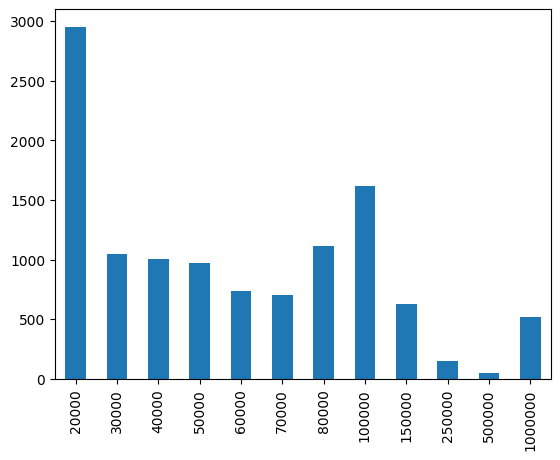

In [290]:
# copy by value
df_income = df.copy()

# nan's
df_income.dropna(inplace=True, subset=['income']) # remove nan's
df_income = df_income[df_income.income != -1] # do not consider the -1 values (nan values)
df_income.shape # (11504, 19) , MAX REDUCTION!

df_income['income'].value_counts().sort_index().plot(kind='bar')

# Age

In [291]:
# Extract Col
age = df.age.unique()
print_col_values(list=age, filename='age')

<AxesSubplot:>

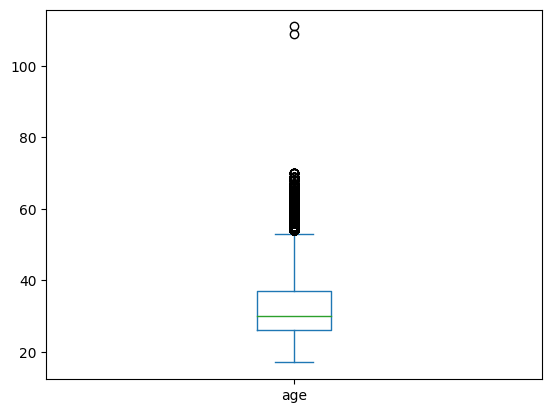

In [292]:
# copy by value
df_age = df.copy()

# nan's
df_age.dropna(inplace=True, subset=['age']) # remove nan's
df_age.shape # (11504, 19) , MAX REDUCTION!

#df_age['age'].value_counts().sort_index().plot(kind='bar', figsize=(12,4))
df_age['age'].plot(kind='box')

# Job

# Offspring

# Orientation

# Pets

# Religion

# Smokes

In [293]:
# Extract Col
smokes = df.smokes.unique()
print_col_values(list=smokes, filename='smokes')

In [294]:
# copy by value
df_smokes = df.copy()

# nan's
df_smokes.dropna(inplace=True, subset=['smokes']) # remove nan's
df_smokes.shape # (54434, 19) , same as profiler

smokes_encoder = category_encoders.OrdinalEncoder(
    cols = ['smokes'],
    return_df = True,
    mapping = [naming['smokes']]
)

df_smokes['smokes_ordinal'] = smokes_encoder.fit_transform(df_smokes['smokes'])
df_smokes[['smokes_ordinal', 'smokes']]

,smokes_ordinal,smokes
0,1,sometimes
1,0,no
2,0,no
3,0,no
4,0,no
...,...,...
59941,0,no
59942,0,no
59943,0,no
59944,2,trying to quit


# Gender

In [297]:
# Extract Col
sex = df.sex.unique()
print_col_values(list=sex, filename='sex')
# copy by value
df_sex = df.copy()

# nan's
df_sex.dropna(inplace=True, subset=['sex']) # remove nan's
df_sex.shape # (59946, 19) , same as profiler

sex_encoder = LabelEncoder()
df_sex['sex_categorical'] = sex_encoder.fit_transform(df_sex['sex'])
df_sex[['sex_categorical', 'sex']]

,sex_categorical,sex
0,1,m
1,1,m
2,1,m
3,1,m
4,1,m
...,...,...
59941,0,f
59942,1,m
59943,1,m
59944,1,m


# Status

In [298]:
# Extract Col
status = df.status.unique()
print_col_values(list=status, filename='status')
# copy by value
df_status = df.copy()

# nan's
df_status.dropna(inplace=True, subset=['status']) # remove nan's
df_status.shape # (59946, 19) , same as profiler

status_encoder = LabelEncoder()
df_status['status_categorical'] = status_encoder.fit_transform(df_status['status'])
df_status[['status_categorical', 'status']]

,status_categorical,status
0,3,single
1,3,single
2,0,available
3,3,single
4,3,single
...,...,...
59941,3,single
59942,3,single
59943,3,single
59944,3,single


# Height